In [4]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft
from data_labeler import calculate_bad_epochs

### Variables

In [5]:
FILTER_RANGE = [0.3,20]
BASE_SAMPLE_RATE = 250

### Upload data

In [6]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]

prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)

# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

### Unpack prodigy

(0.0, 5.0)

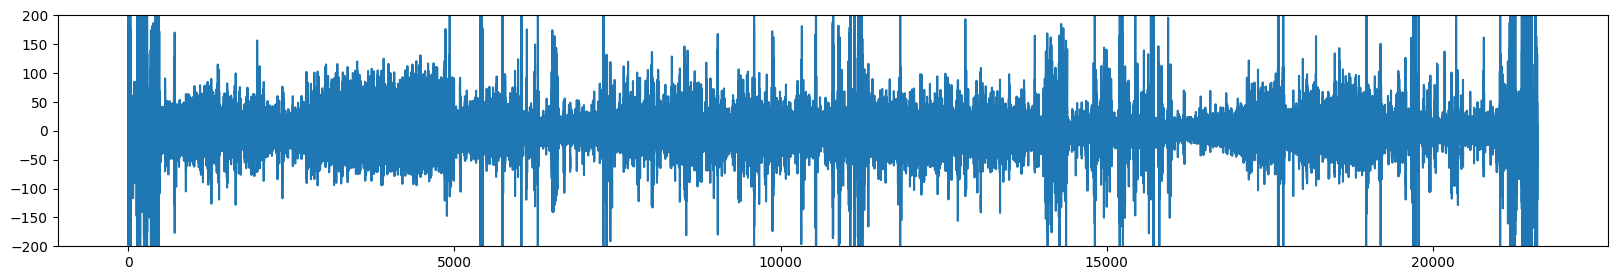

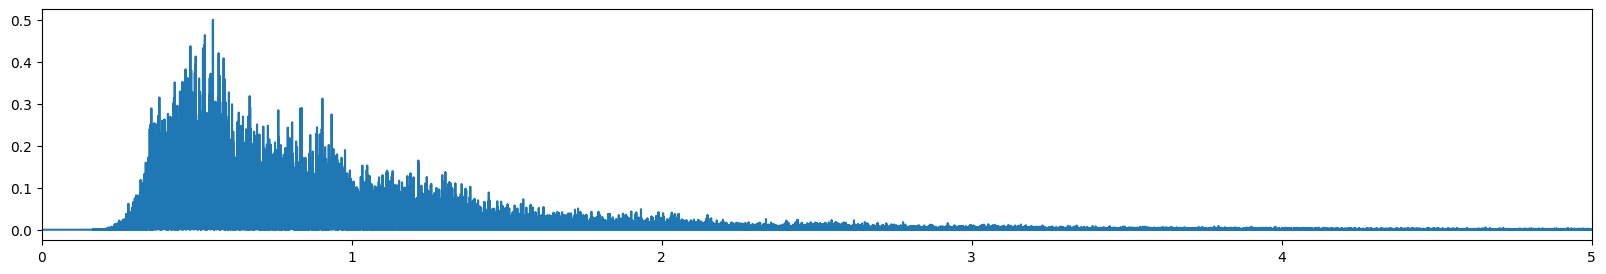

In [30]:
CHANNEL_1 = "LEFT_EYE"
CHANNEL_2 = "RIGHT_EYE"
PRODIGY_SAMPLE_RATE = 120
prodigy_data, prodigy_times = prodigy_raw_data[:, :]
prodigy_channel_names = prodigy_raw_data.ch_names

# find the position of the channels in channel_names
channel_1_index = prodigy_channel_names.index(CHANNEL_1)
channel_2_index = prodigy_channel_names.index(CHANNEL_2)
# extract the data from the channels
prodigy_channel_1_data = prodigy_data[channel_1_index, :]
prodigy_channel_2_data = prodigy_data[channel_2_index, :]
# minus right eye from left eye
prodigy_channel_1_minus_2 = prodigy_channel_1_data - prodigy_channel_2_data
prodigy_channel_1_minus_2 = prodigy_channel_1_minus_2*1000000

# Upsample to 250 Hz
num_samples_250 = int(BASE_SAMPLE_RATE/PRODIGY_SAMPLE_RATE*len(prodigy_channel_1_minus_2))
resampled_prodigy_data = resample(prodigy_channel_1_minus_2, num_samples_250)

# Filter
prodigy_filtered_data_rs = do_bandpass(resampled_prodigy_data,  [FILTER_RANGE[0], FILTER_RANGE[1]], BASE_SAMPLE_RATE)
resampled_times = np.linspace(0, len(prodigy_filtered_data_rs)/BASE_SAMPLE_RATE, len(prodigy_filtered_data_rs))


plt.figure(figsize=(20, 3))
plt.plot(resampled_times, resampled_prodigy_data)
plt.ylim(-200, 200)

pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, 0,20, BASE_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(pr_freqs_rs, pr_fft_rs)
plt.xlim(0, 5)


### Unpack IDUN

(0.0, 5.0)

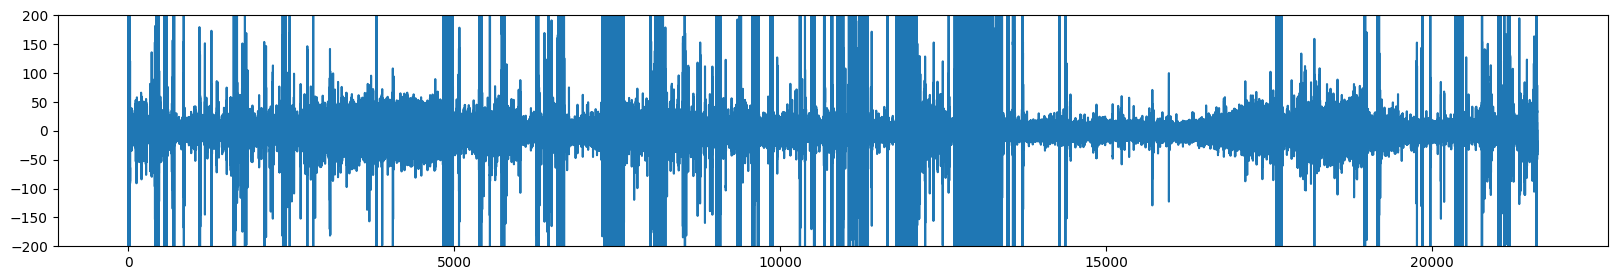

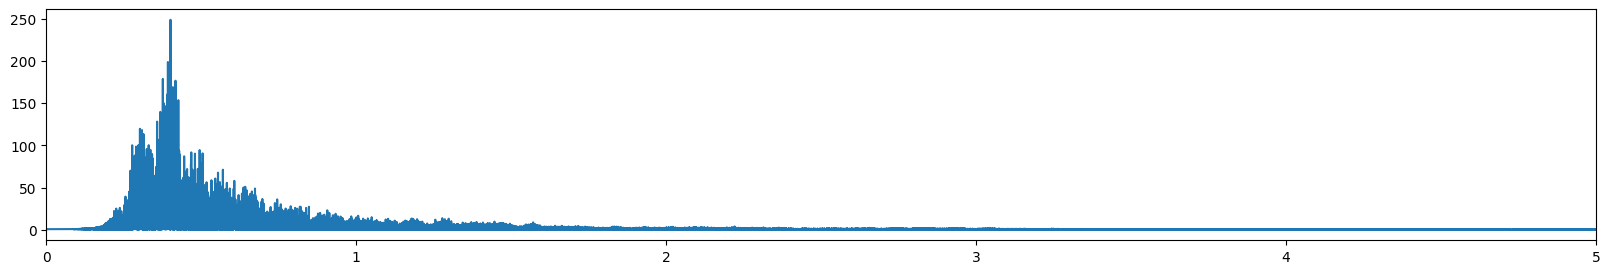

In [40]:
IDUN_SAMPLE_RATE = 250
idun_data = idun_raw_data[:,1]
idun_time_stamps = idun_raw_data[:,0]
idun_time_stamps = idun_time_stamps - idun_time_stamps[0]

# bandpass filter
idun_filtered_data = do_bandpass(idun_data, [FILTER_RANGE[0], FILTER_RANGE[1]], IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)

id_freqs, id_fft = prepare_fft(idun_filtered_data, 0,30 ,IDUN_SAMPLE_RATE)
plt.figure(figsize=(20, 3))
plt.plot(id_freqs, id_fft)
plt.xlim(0,5)

### Clean data

In [37]:
prodigy_labels, prodigy_epoch_freq_powers = calculate_bad_epochs(prodigy_filtered_data_rs, sfreq = BASE_SAMPLE_RATE, outlier_threshold = 3, epoch_length = BASE_SAMPLE_RATE)
prodigy_cleaned_data = np.where(prodigy_labels == 1, np.nan, prodigy_filtered_data_rs)

idun_labels, idun_epoch_freq_powers = calculate_bad_epochs(idun_filtered_data, sfreq = BASE_SAMPLE_RATE, outlier_threshold = 3, epoch_length = BASE_SAMPLE_RATE)
idun_cleaned_data = np.where(idun_labels == 1, np.nan, idun_filtered_data)

(-200.0, 200.0)

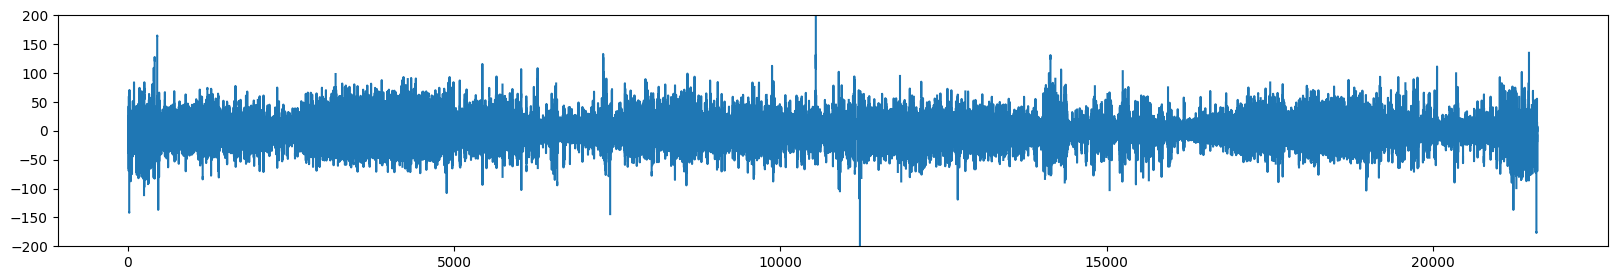

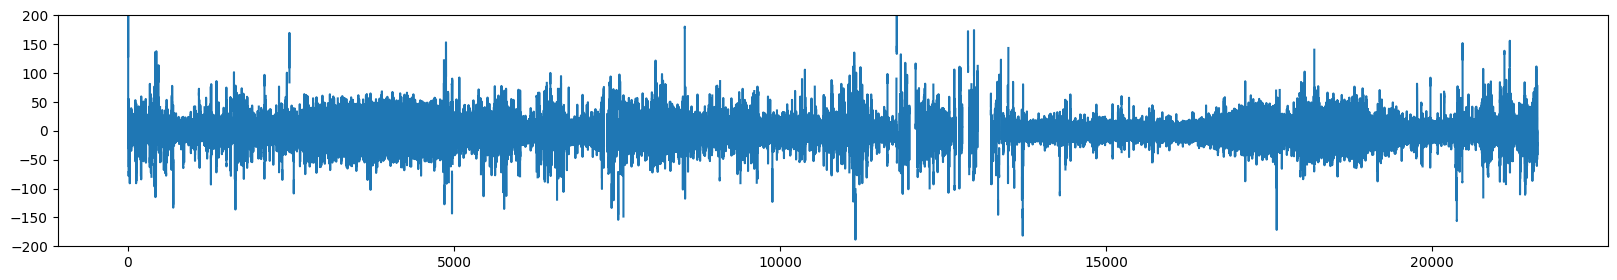

In [42]:
plt.figure(figsize=(20, 3))
# make 0s 1s and 1s 0s in prodigy_labels
plt.plot(resampled_times, prodigy_cleaned_data)
plt.ylim(-200, 200)

plt.figure(figsize=(20, 3))
# make 0s 1s and 1s 0s in prodigy_labels
plt.plot(idun_time_stamps, idun_cleaned_data)
plt.ylim(-200, 200)

### Sync data